In [1]:
from tqdm import tqdm_notebook
from config import config
from util import utils
from processer import load_data

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load data into memory and sanity check

In [3]:
img_list, label_list = load_data.load_and_resize(config.TRAIN_LABELS, config.TRAIN_DIR)

processing 500 / 2725
processing 1000 / 2725
processing 1500 / 2725
processing 2000 / 2725
processing 2500 / 2725


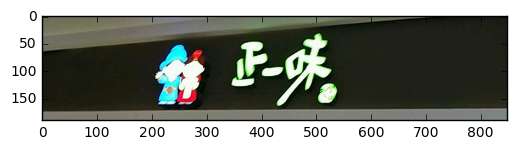

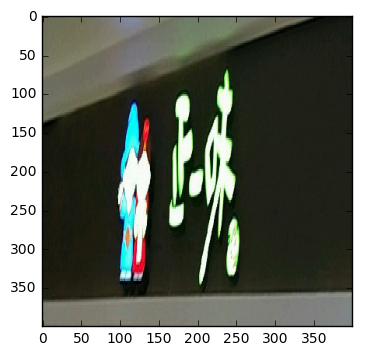

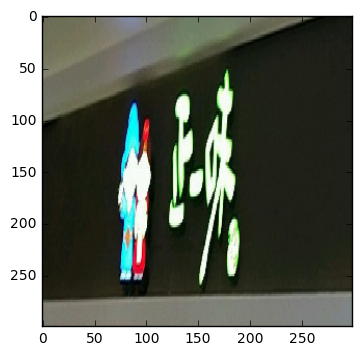

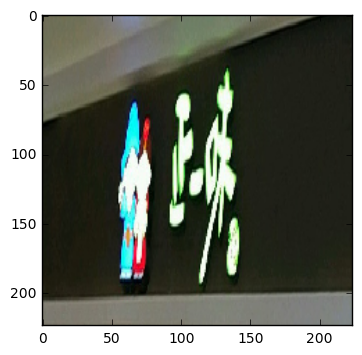

In [4]:
utils.show_img(img_list[0][1])
utils.show_img(img_list[1][1])
utils.show_img(img_list[2][1])
utils.show_img(img_list[3][1])

In [5]:
label_list[1]

98

# Split the Data

In [6]:
from sklearn.model_selection import train_test_split

In [11]:
X = []
for i in range(len(img_list)):
    if i == 0: continue
    X.append(np.asarray(img_list[i]))
y_ = utils.to_one_hot(np.asarray(label_list))

In [14]:
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(len(X)):
    X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X[i], y_, test_size=0.2,
                                                                            random_state=config.random_seed)
    X_train.append(X_temp_train)
    X_test.append(X_temp_test)
    y_train.append(y_temp_train)
    y_test.append(y_temp_test)

## Sanity check

In [20]:
for i in range(len(X_train)):
    print('X_train[{}].shape: '.format(i) + str(X_train[i].shape))
    print('X_test[{}].shape: '.format(i) + str(X_test[i].shape))
    print('y_train[{}].shape: '.format(i) + str(y_train[i].shape))
    print('y_test[{}].shape: '.format(i) + str(y_test[i].shape))
    print()

X_train[0].shape: (2180, 400, 400, 3)
X_test[0].shape: (545, 400, 400, 3)
y_train[0].shape: (2180, 100)
y_test[0].shape: (545, 100)

X_train[1].shape: (2180, 299, 299, 3)
X_test[1].shape: (545, 299, 299, 3)
y_train[1].shape: (2180, 100)
y_test[1].shape: (545, 100)

X_train[2].shape: (2180, 224, 224, 3)
X_test[2].shape: (545, 224, 224, 3)
y_train[2].shape: (2180, 100)
y_test[2].shape: (545, 100)



# Model Averageing
from [here](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/code)

request: the model defined needs to have fit() and predict() methods

In [8]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [9]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [10]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

# Make submission

In [11]:
import pandas as pd
sub = pd.DataFrame()